In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import astropy.units as u
from astropy.io import fits
from pathlib import Path
from IPython.display import clear_output, display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))


from importlib import reload


import poppy

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import scoobpsf
from scoobpsf.math_module import xp, _scipy
from scoobpsf.imshows import *
from scoobpsf import scoob

import lina

pupil_diam = 6.75*u.mm 
lyot_diam = 3.6*u.mm

wavelength_c = 632.8e-9*u.m # central wavelength
npix = 512
oversample = 8

vortex = scoobpsf.agpm.IdealAGPM(name='VVC', wavelength=wavelength_c, charge=6, singularity=20*u.um)
lyot_stop = poppy.CircularAperture(name='Lyot Stop', radius=lyot_diam/2.0)
wfs_lyot_stop = poppy.InverseTransmission(lyot_stop)


In [11]:
reload(scoob)
model = scoob.SCOOBM()

No OPD data implemented into model.
Using default Gaussian influence function.
Using reflection when computing OPD.


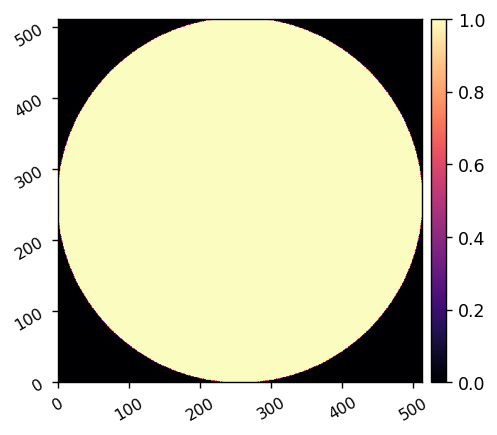

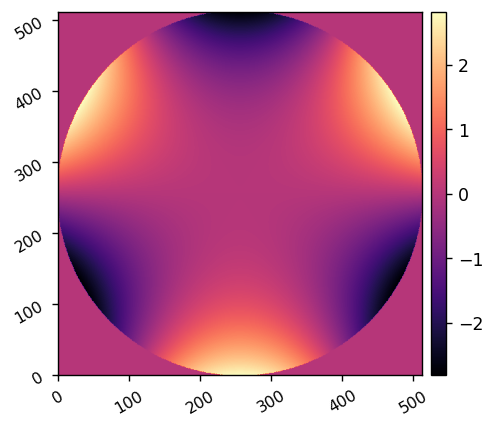

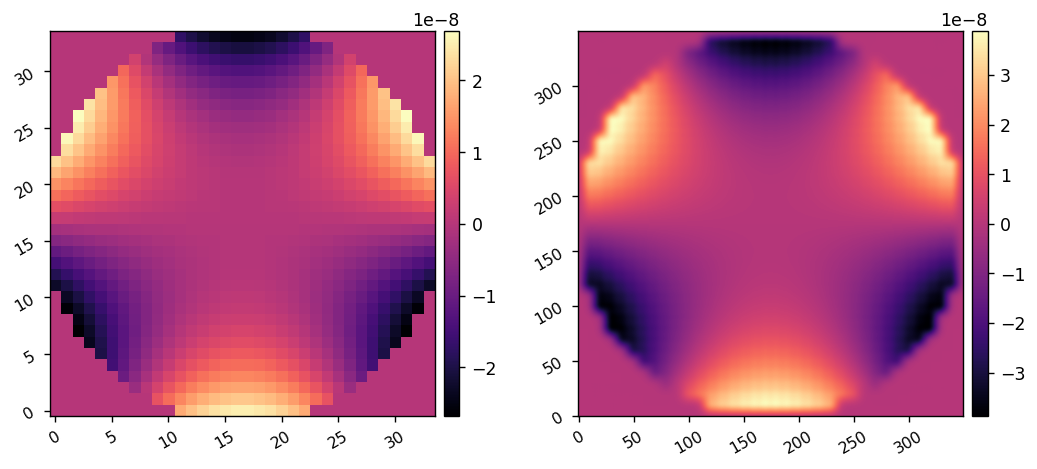

In [15]:
wf = poppy.Wavefront(diam=model.pupil_diam, npix=512, oversample=1)
pupil_mask = poppy.CircularAperture(radius=model.pupil_diam/2, name='Pupil').get_transmission(wf).astype(bool)
imshow1(pupil_mask)

reload(lina.llowfsc)
zmodes = lina.llowfsc.create_zernike_modes(pupil_mask, nmodes=15)[1:]
imshow1(zmodes[7])

dm_zernikes = lina.llowfsc.create_zernike_modes(model.dm_mask)[1:]
model.set_dm(dm_zernikes[7]*1e-8)
imshow2(dm_zernikes[7]*1e-8, model.DM.get_surface())
model.reset_dm()


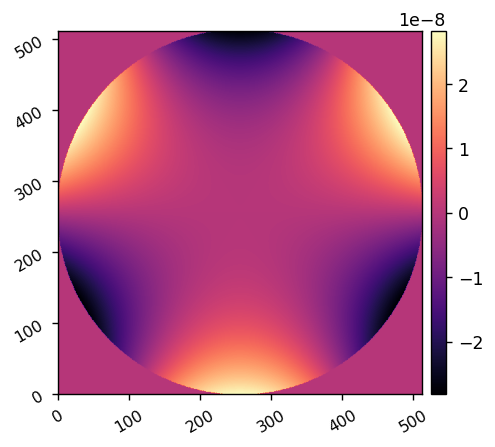

In [25]:
model.RETRIEVED = poppy.ArrayOpticalElement(opd=zmodes[7]*1e-8, pixelscale=model.pupil_diam/(model.npix*u.pix))
imshow1(model.RETRIEVED.opd)

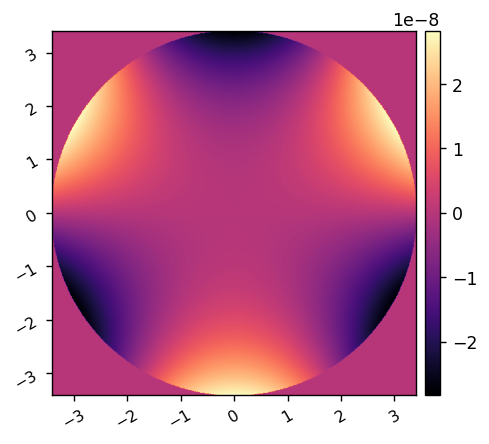

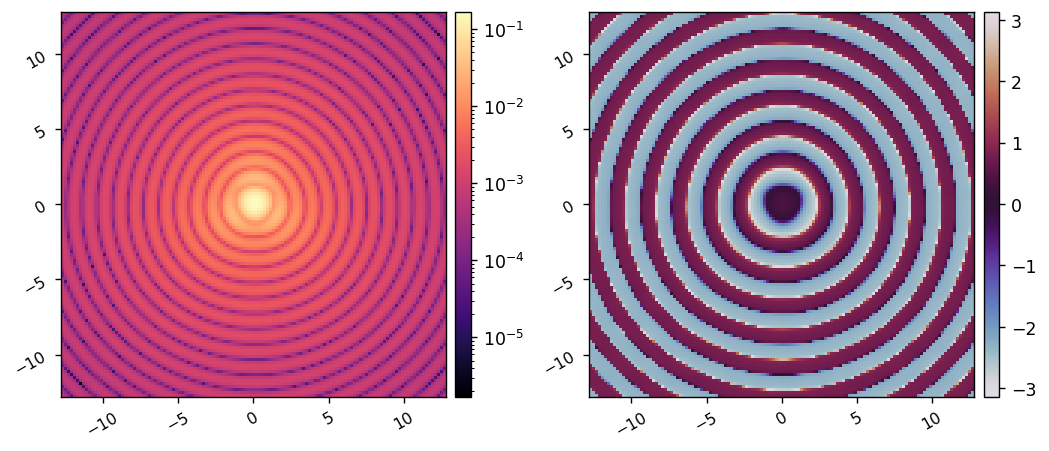

In [26]:
model.npsf = 128
model.RETRIEVED = poppy.ArrayOpticalElement(opd=zmodes[7]*1e-8, pixelscale=model.pupil_diam/(2*model.npix*u.pix))
imwf = model.calc_wf(plot=True)

In [52]:
reload(scoob)
model = scoob.SCOOBM()

model.npix = 256
model.oversample = 32

No OPD data implemented into model.
Using default Gaussian influence function.
Using reflection when computing OPD.


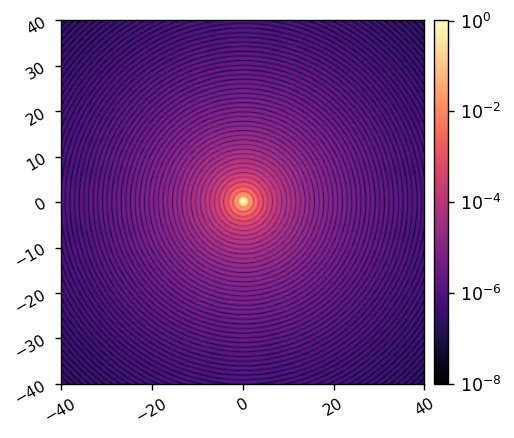

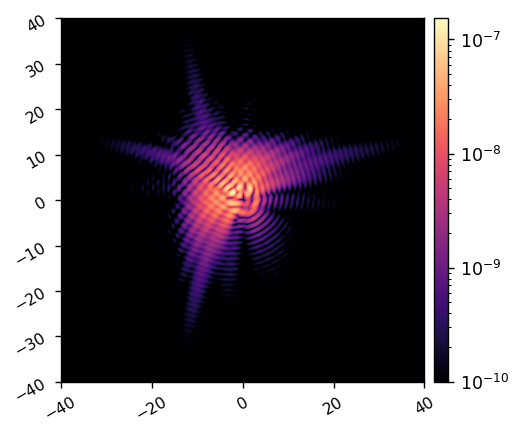

In [53]:
model.Imax_ref = model.snap().max()

ref_psf = model.snap(plot=True, vmin=1e-8)

model.FPM = vortex
model.LYOT = lyot_stop

ref_im = model.snap(plot=True, vmin=1e-10)

In [54]:
model.use_llowfsc = True
model.llowfsc_defocus = 2.5*u.mm
model.nllowfsc = 64

model.FPM = vortex
model.LYOT = wfs_lyot_stop


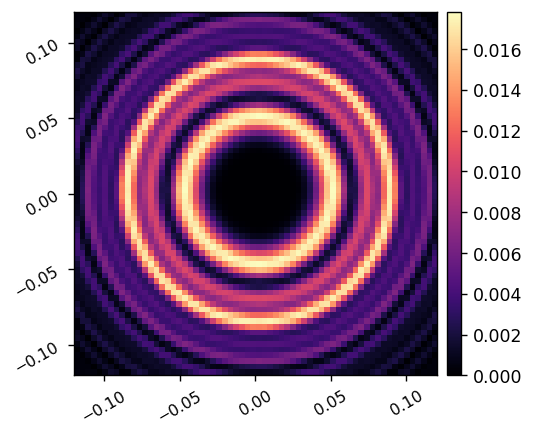

In [55]:
model.reset_dm()
im = model.snap()
imshow1(im, pxscl=model.llowfsc_pixelscale.to(u.mm/u.pix))

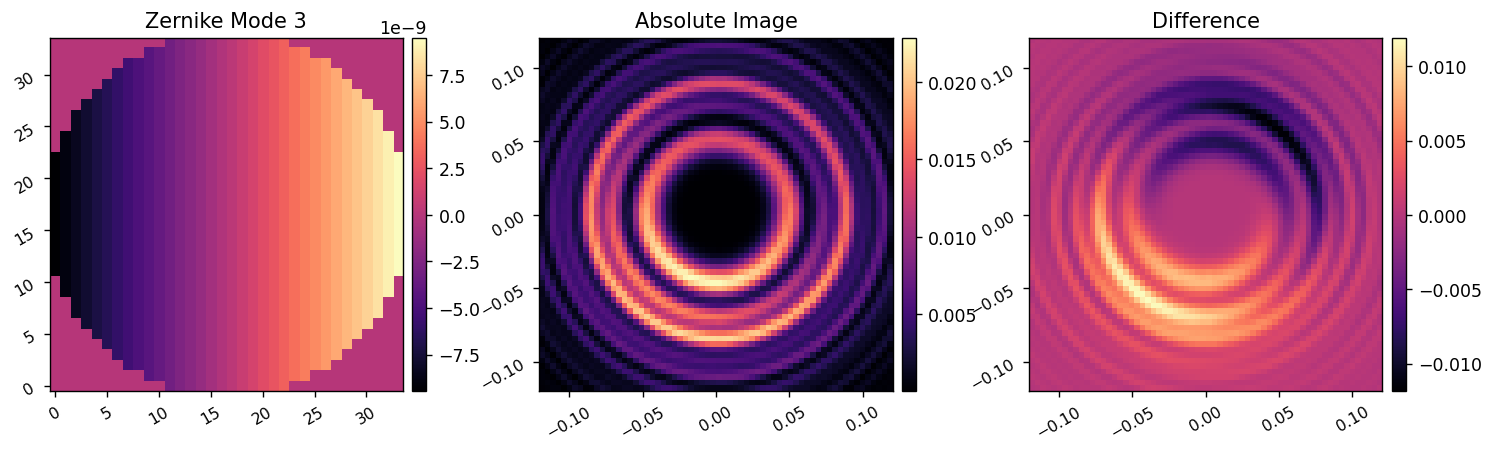

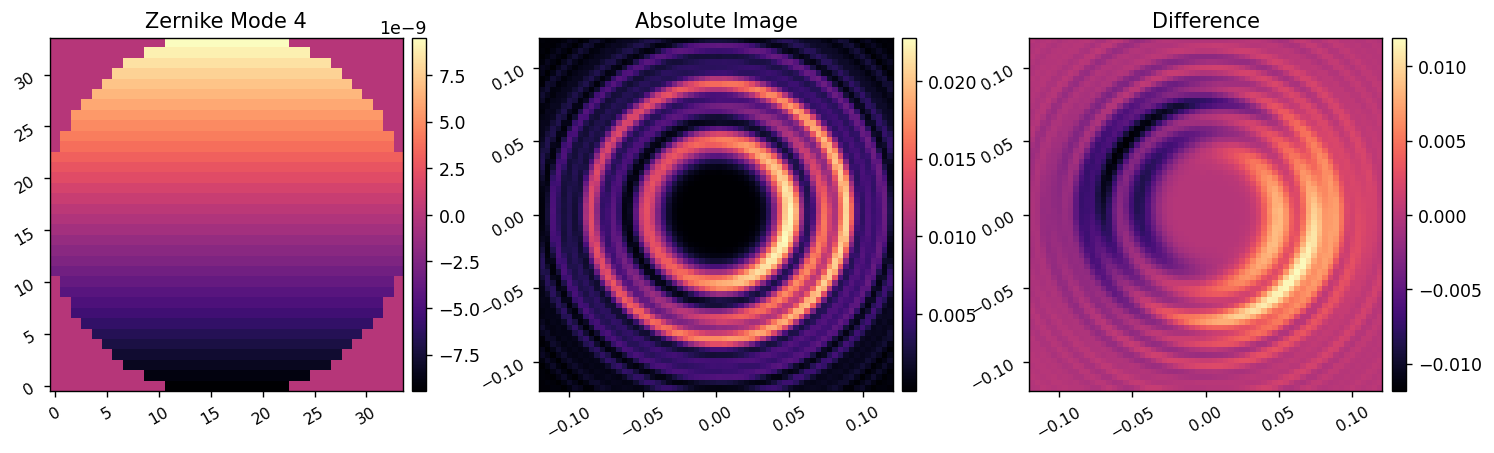

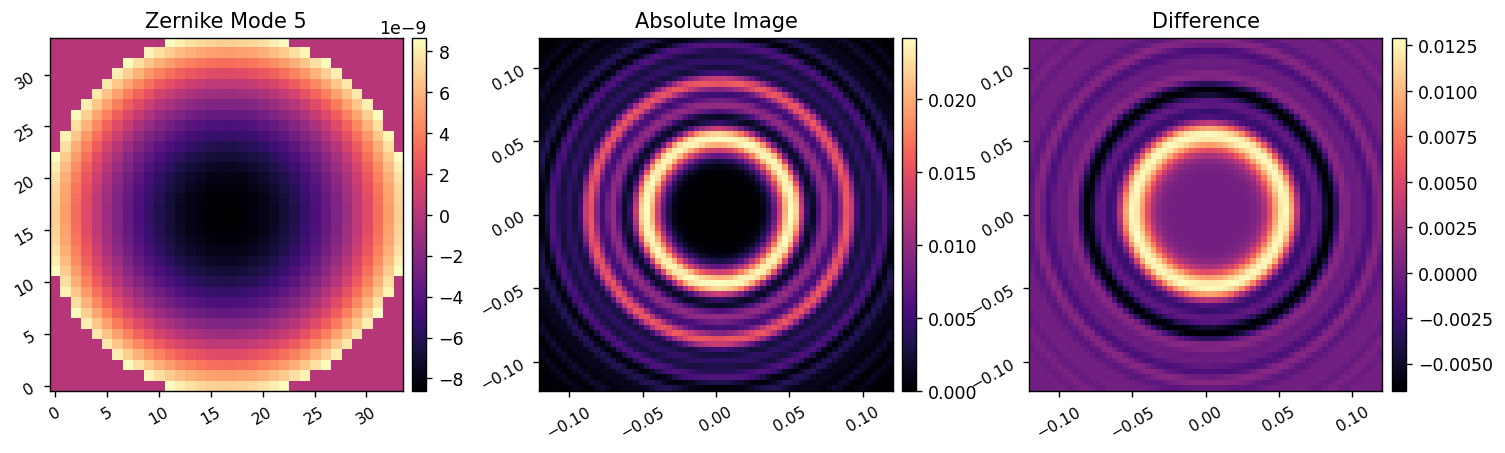

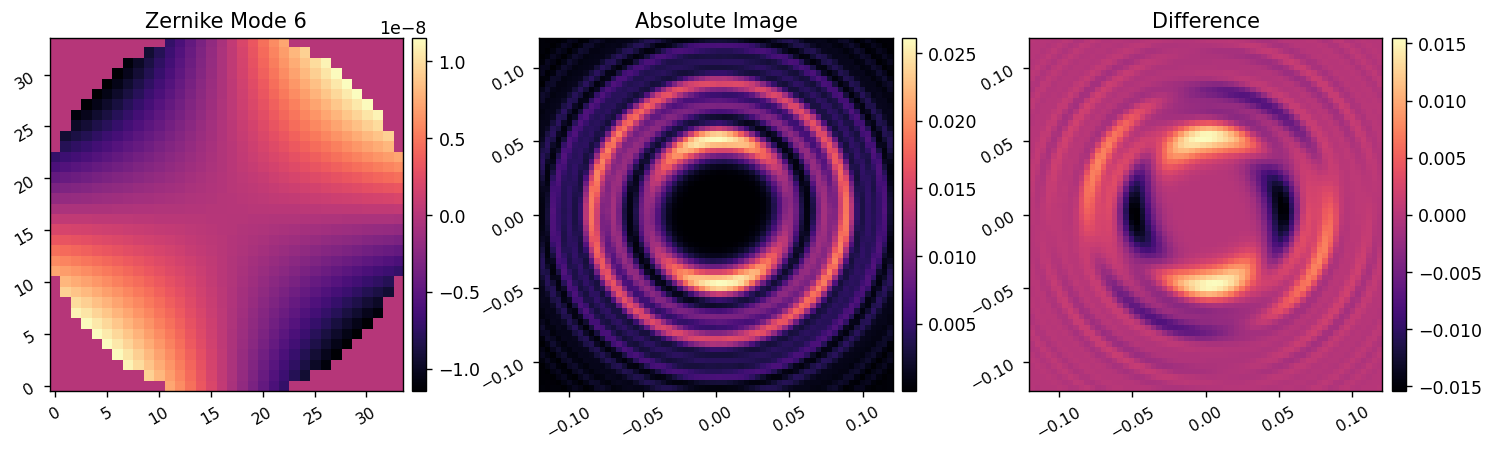

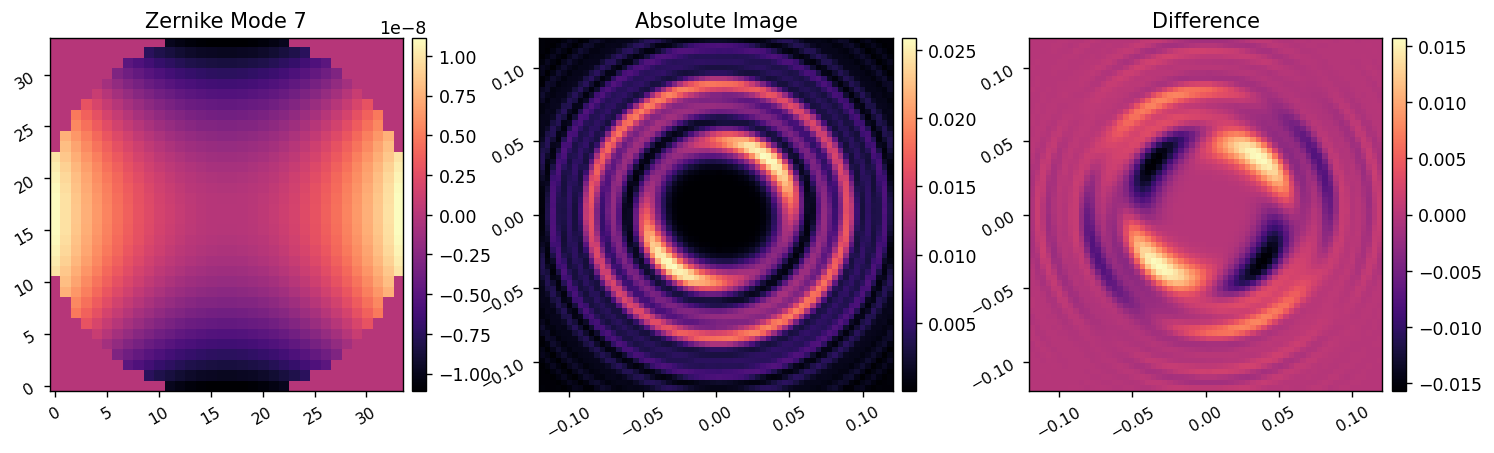

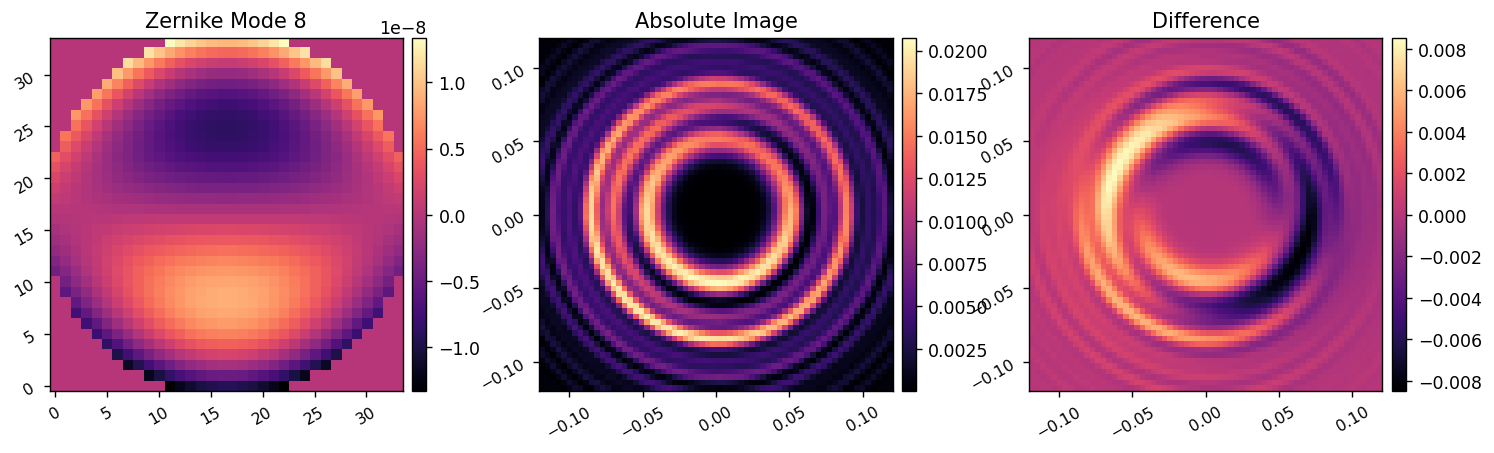

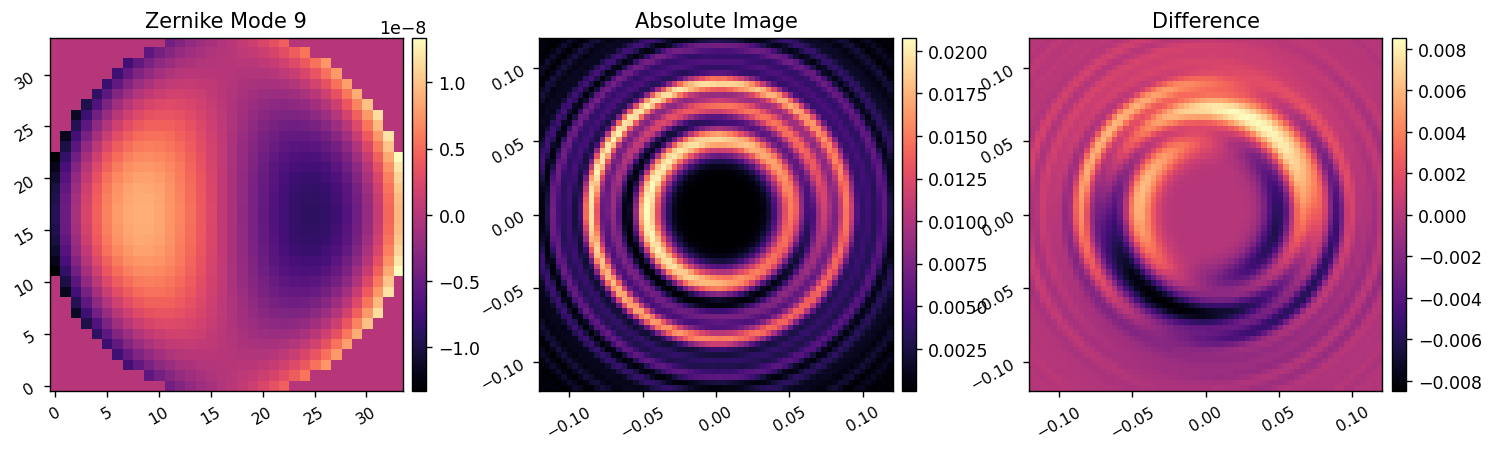

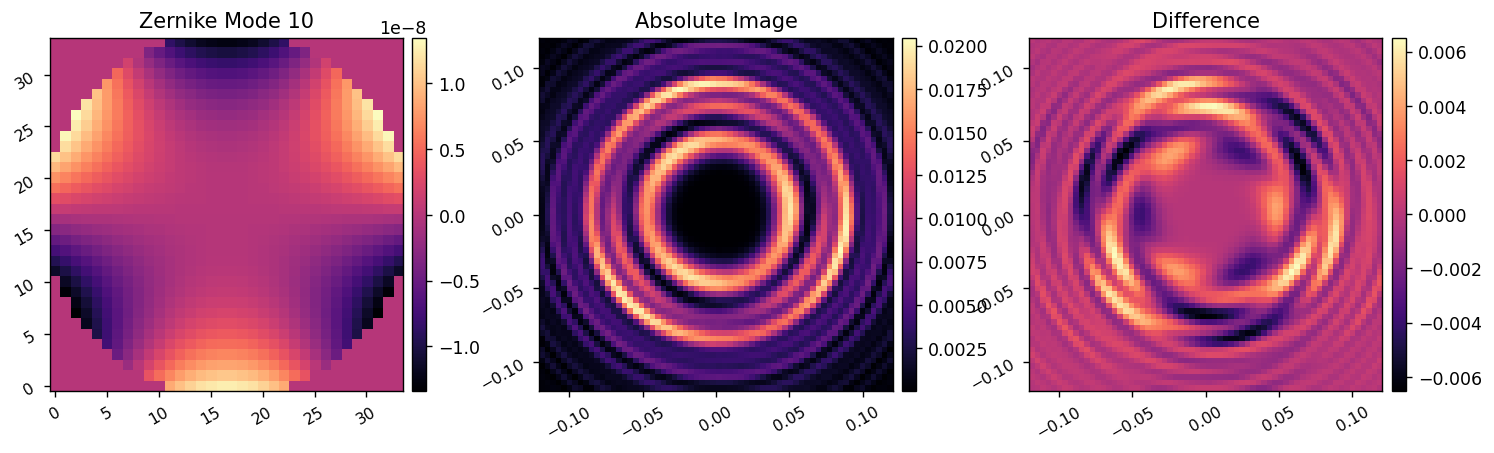

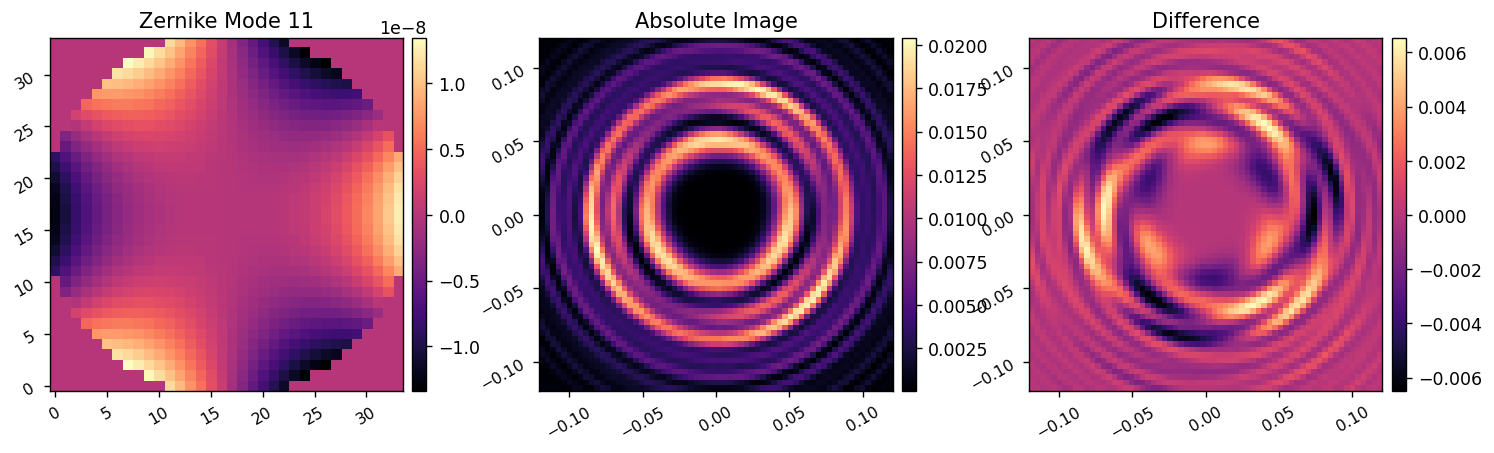

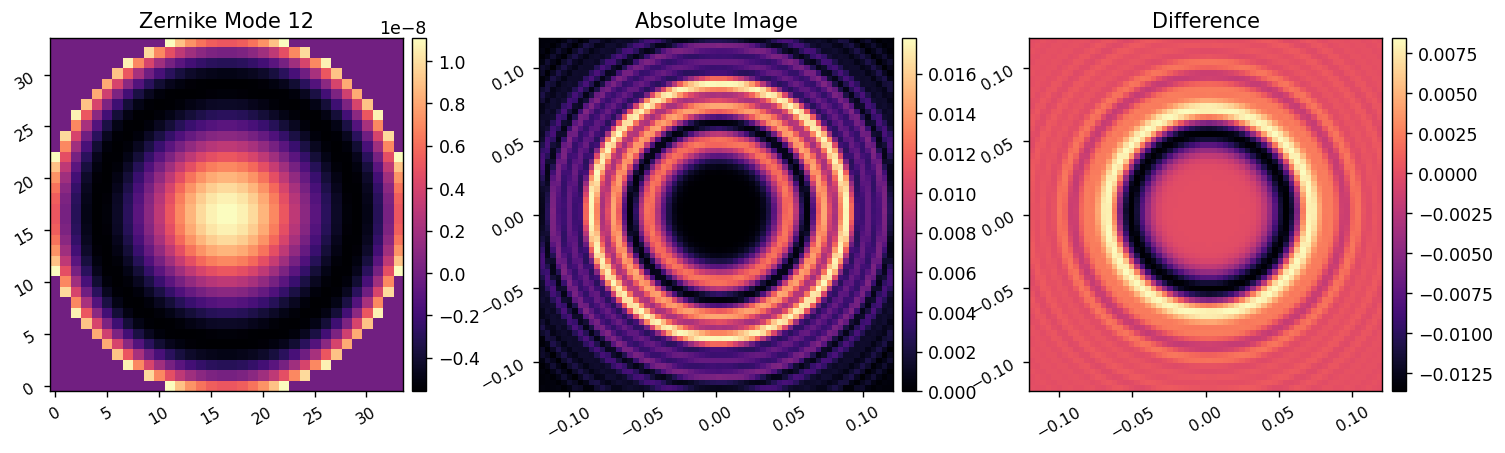

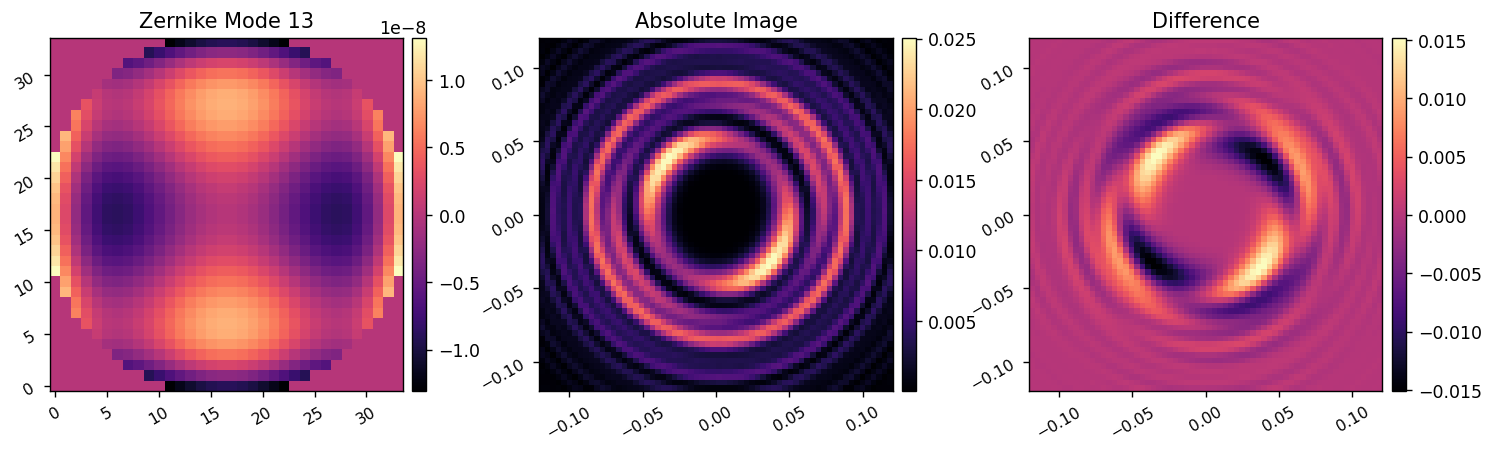

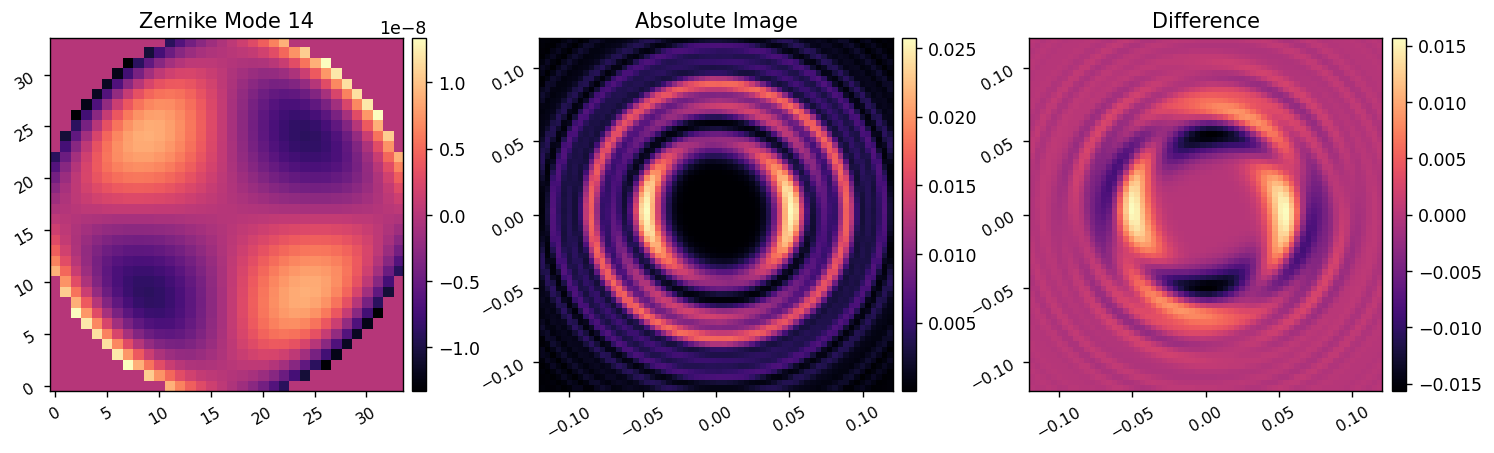

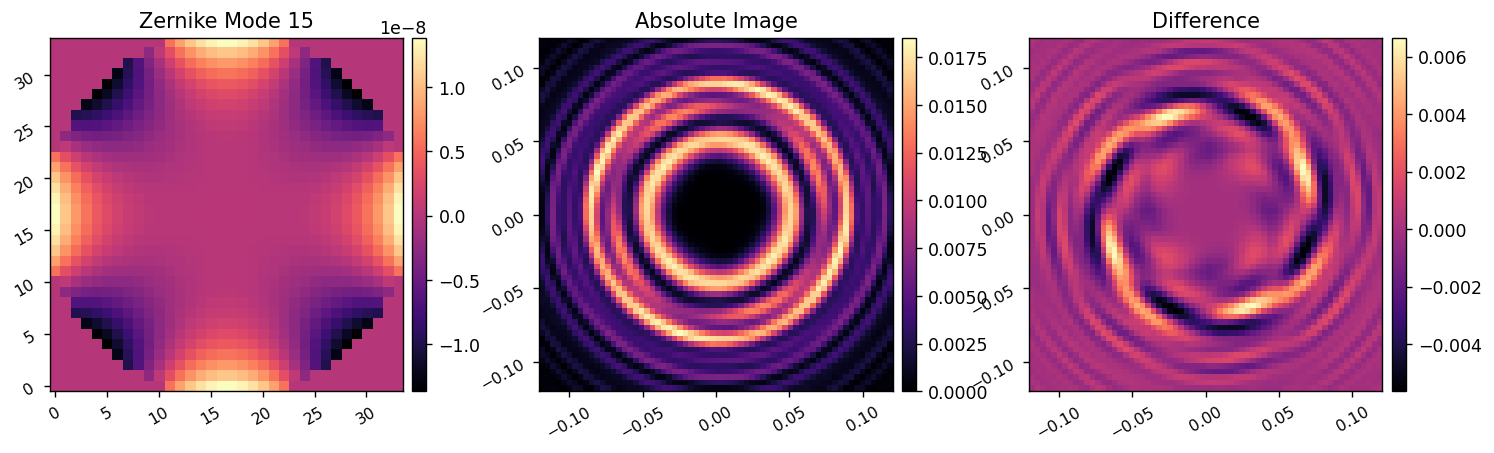

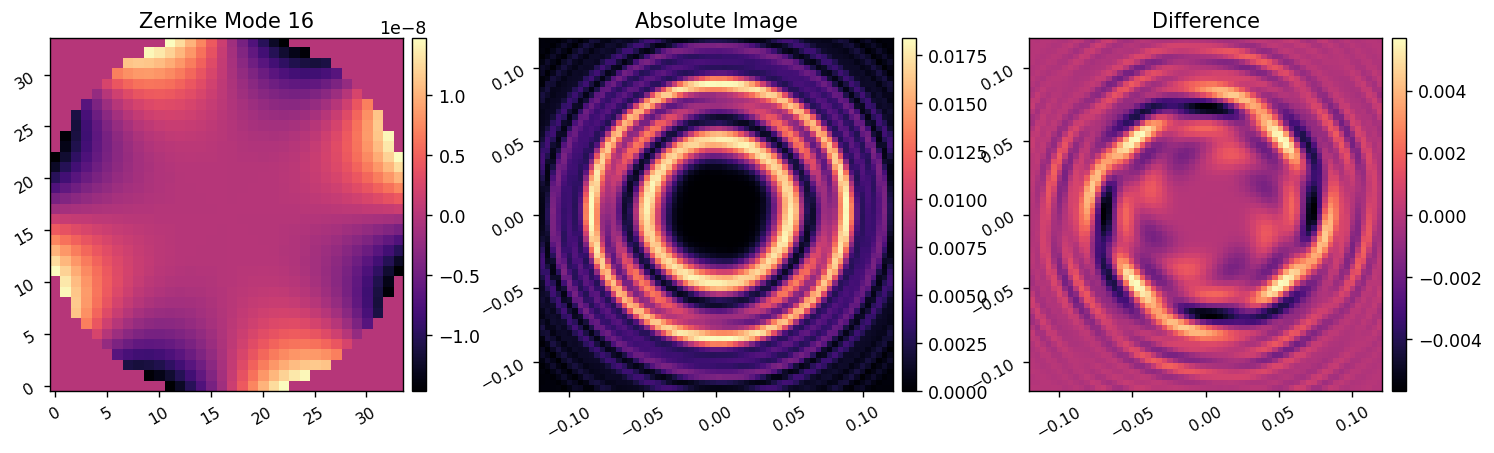

In [56]:
amp = 5e-9

im_ref = model.snap()

responses = xp.zeros((dm_zernikes.shape[0], model.nllowfsc**2))
for i,mode in enumerate(dm_zernikes):
    # model.RETRIEVED = poppy.ArrayOpticalElement(opd=mode*1e-8, pixelscale=model.pupil_diam/(2*model.npix*u.pix))
    # im_pos = model.snap()

    model.set_dm(amp*mode)
    im_pos = model.snap()
    model.add_dm(-amp*mode)

    model.add_dm(-amp*mode)
    im_neg = model.snap()
    model.add_dm(amp*mode)

    # diff = im_pos-im_ref
    # responses[i] = diff.flatten()/amp

    diff = im_pos - im_neg
    responses[i] = diff.flatten()/(2*amp)

    imshow3(amp*mode, im_pos, diff, f'Zernike Mode {i+3}', 'Absolute Image', 'Difference', 
            pxscl2=model.llowfsc_pixelscale.to(u.mm/u.pix), pxscl3=model.llowfsc_pixelscale.to(u.mm/u.pix))

response_matrix = responses.T

In [58]:
control_matrix = lina.utils.beta_reg(response_matrix, -6)
# control

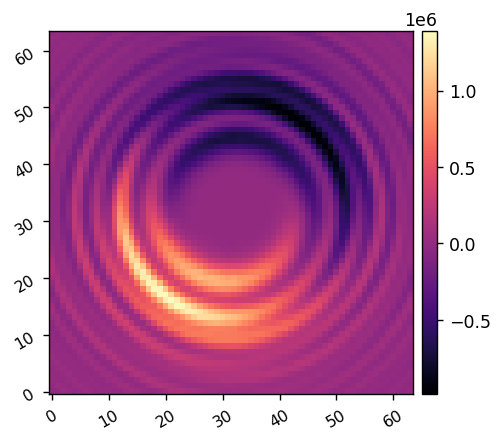

In [116]:
imshow1(responses[0].reshape(model.nllowfsc, model.nllowfsc))

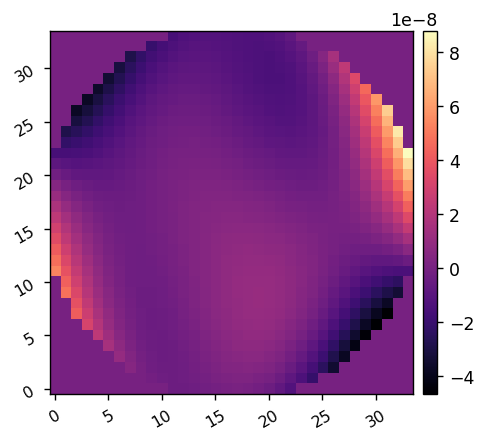

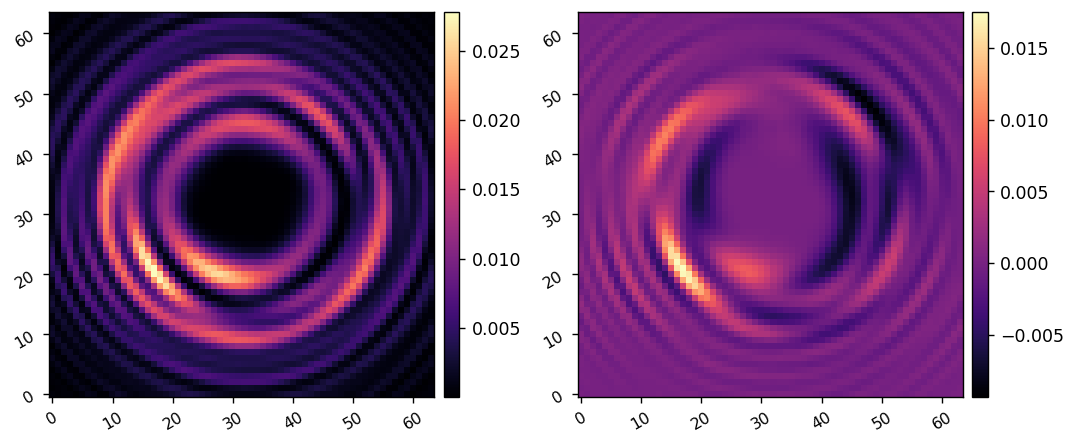

In [83]:
# amps = 10e-9*(np.random.rand(dm_zernikes.shape[0])-1/2) + 10e-9
amps = 3e-9*(np.random.randn(dm_zernikes.shape[0])) + 3e-9

# amps = 3e-9*(np.random.randn(zmodes.shape[0])) + 3e-9

lo_wfe = 0
for i in range(dm_zernikes.shape[0]):
    lo_wfe += amps[i]*dm_zernikes[i]
    # lo_wfe += amps[i]*zmodes[i]
imshow1(lo_wfe)

model.set_dm(lo_wfe)
# model.RETRIEVED = poppy.ArrayOpticalElement(opd=lo_wfe, pixelscale=model.pupil_diam/(2*model.npix*u.pix))
model.RETRIEVED = None
im = model.snap()

diff = im - im_ref

imshow2(im, diff)

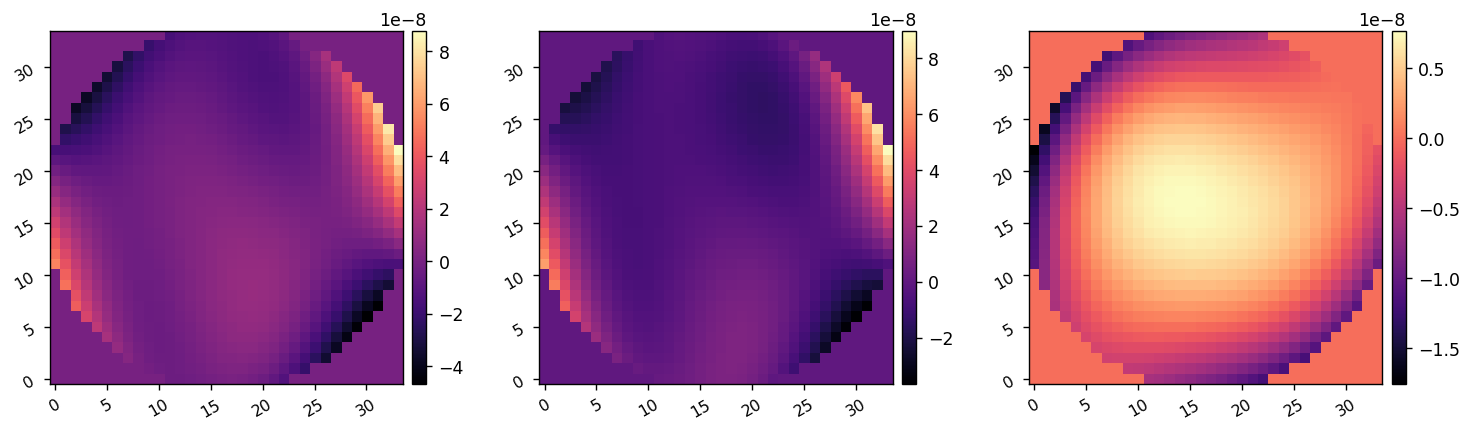

In [84]:
modal_coeff = control_matrix.dot(im.flatten())

est_lo_wfe = 0
for i in range(len(modal_coeff)):
    # est_lo_wfe += modal_coeff[i]*zmodes[i]
    est_lo_wfe += modal_coeff[i]*dm_zernikes[i]
imshow3(lo_wfe, est_lo_wfe, lo_wfe-est_lo_wfe)

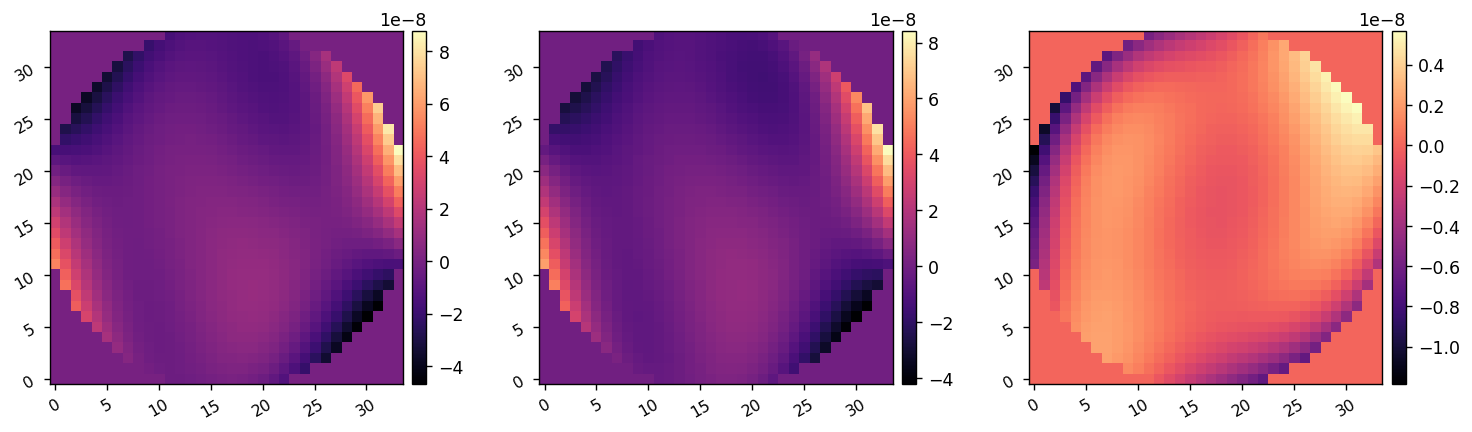

In [85]:
modal_coeff = control_matrix.dot(diff.flatten())

est_lo_wfe = 0
for i in range(len(modal_coeff)):
    # est_lo_wfe += modal_coeff[i]*zmodes[i]
    est_lo_wfe += modal_coeff[i]*dm_zernikes[i]
imshow3(lo_wfe, est_lo_wfe, lo_wfe-est_lo_wfe)

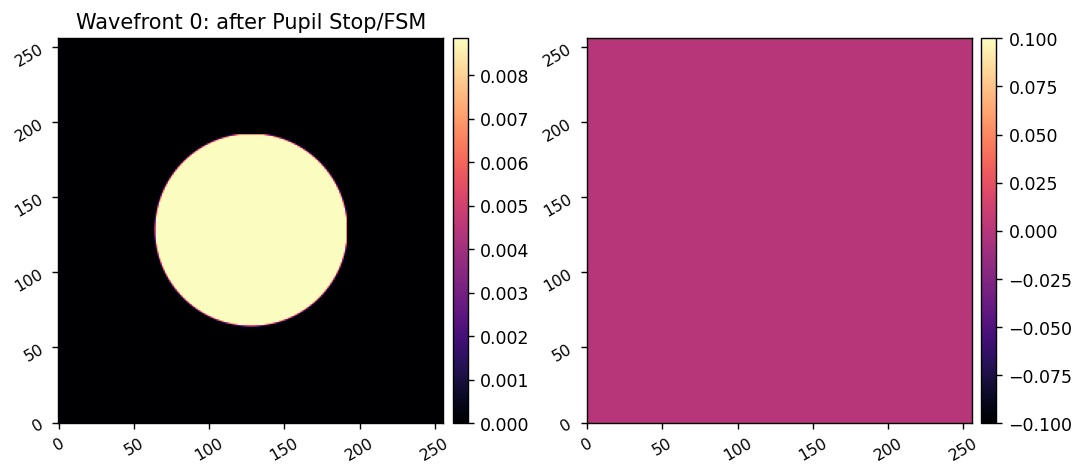

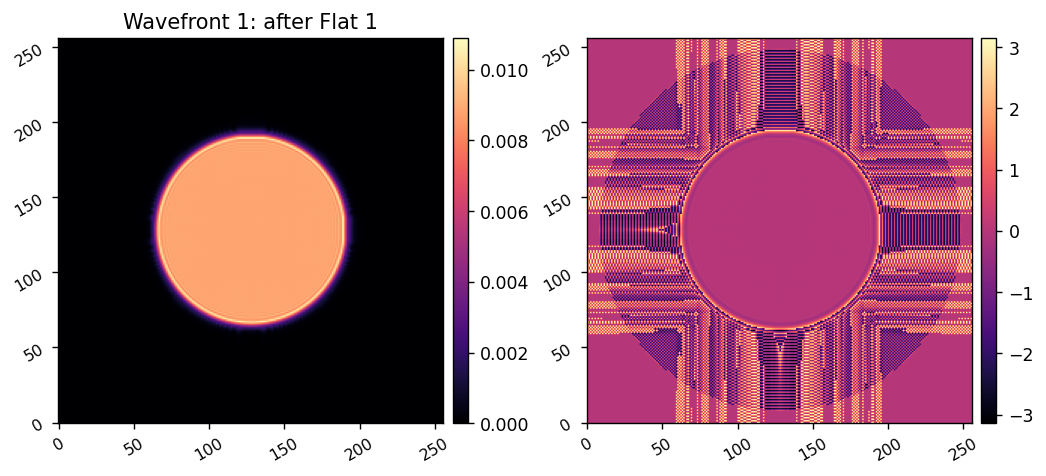

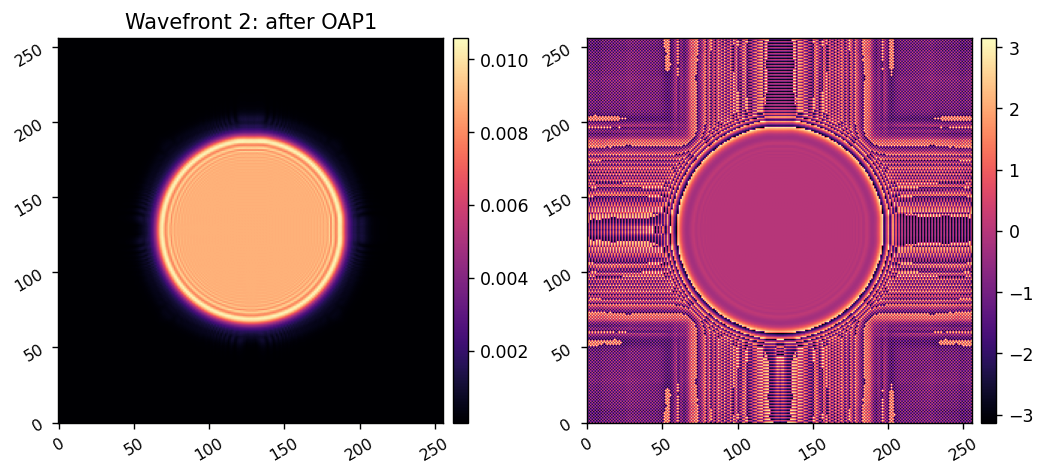

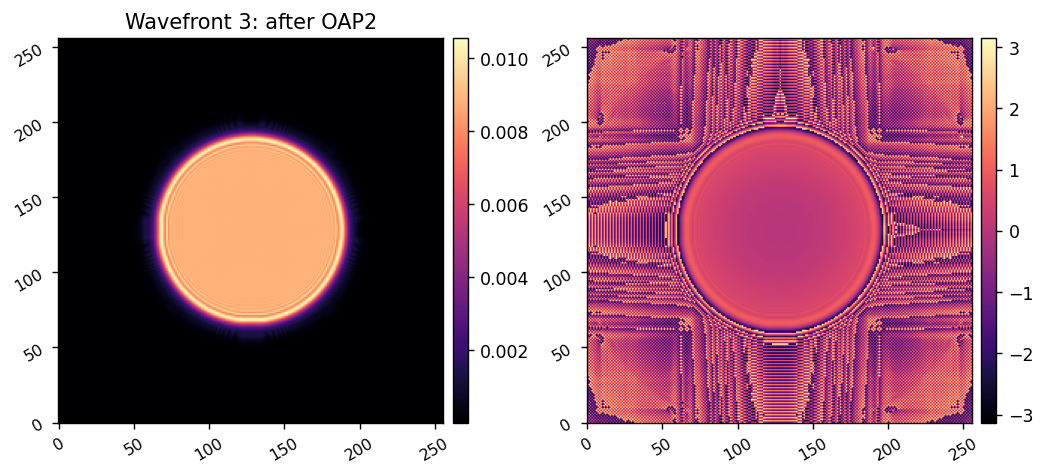

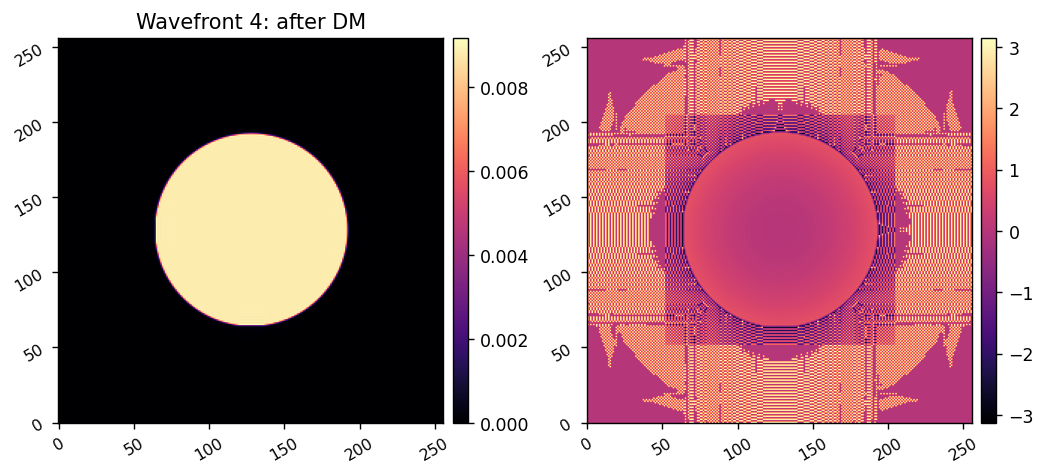

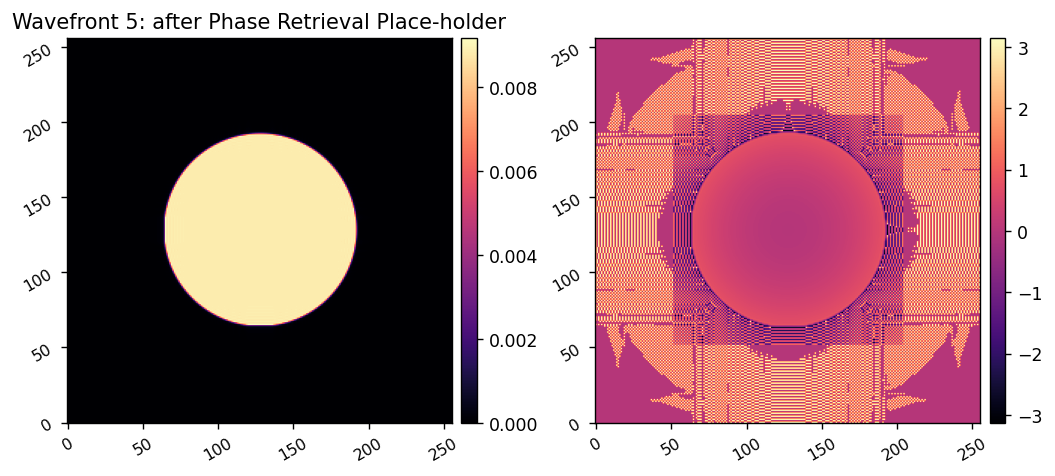

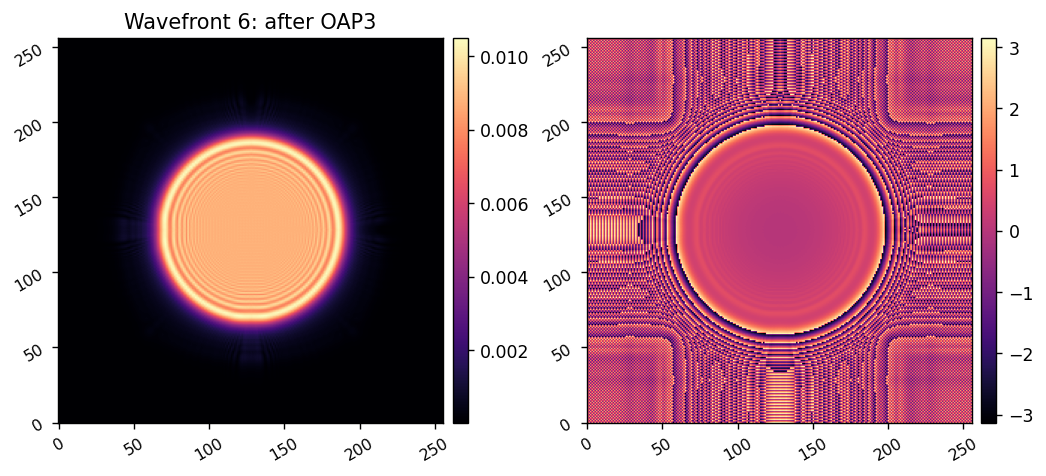

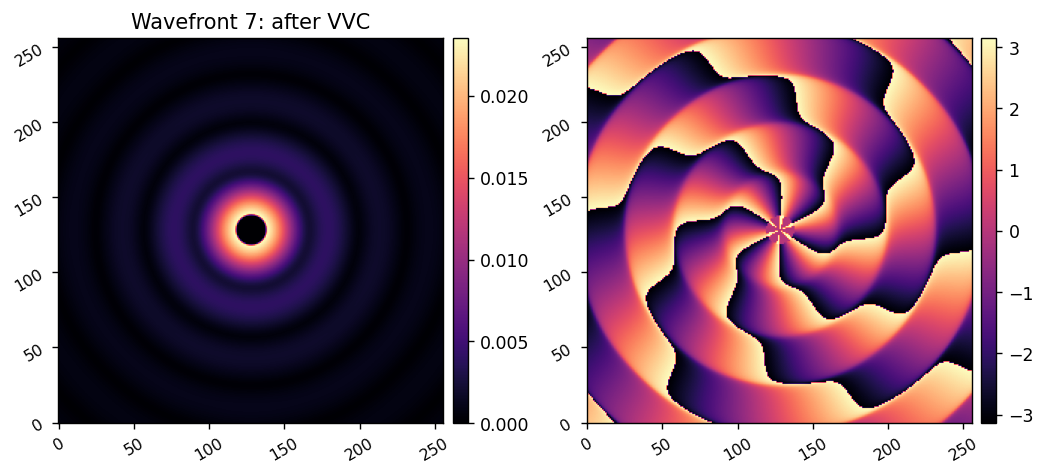

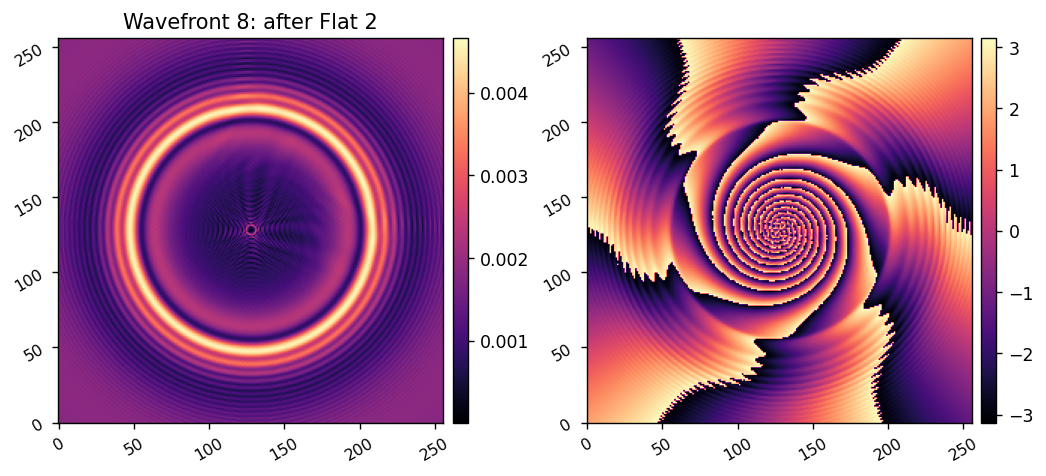

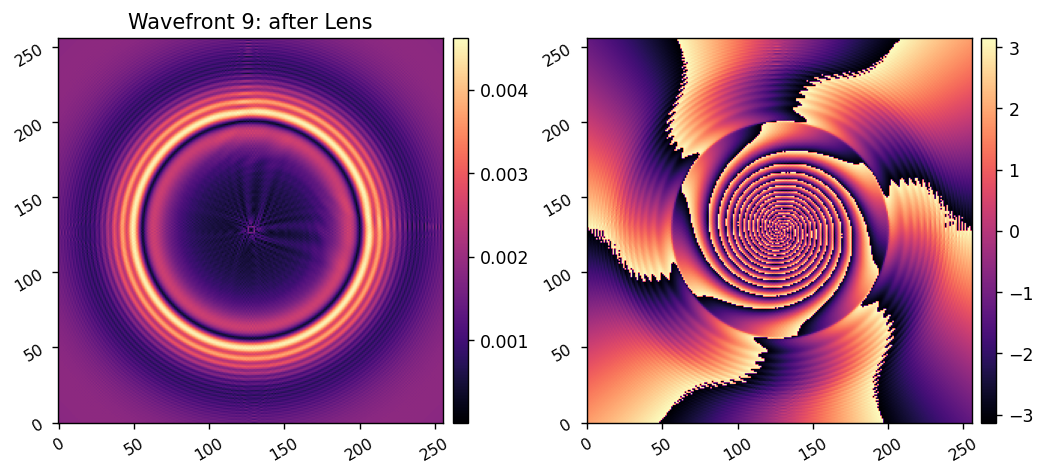

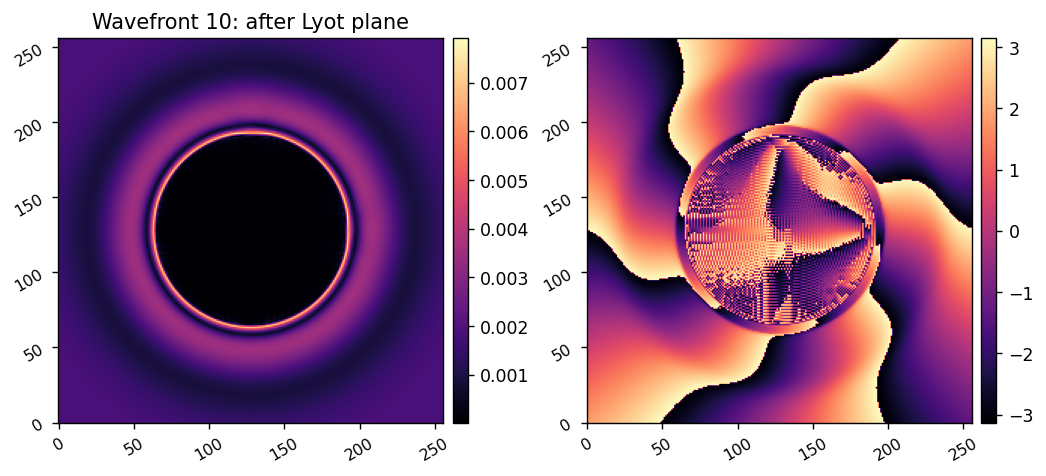

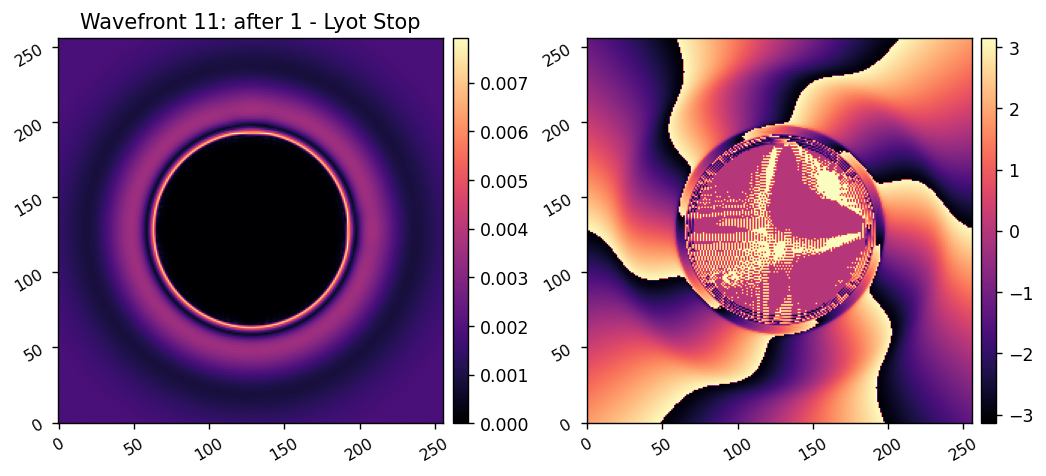

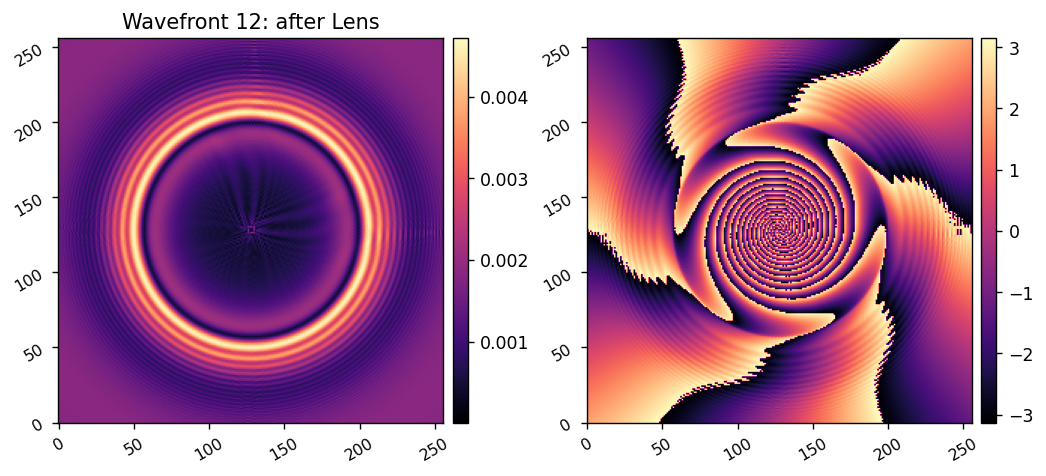

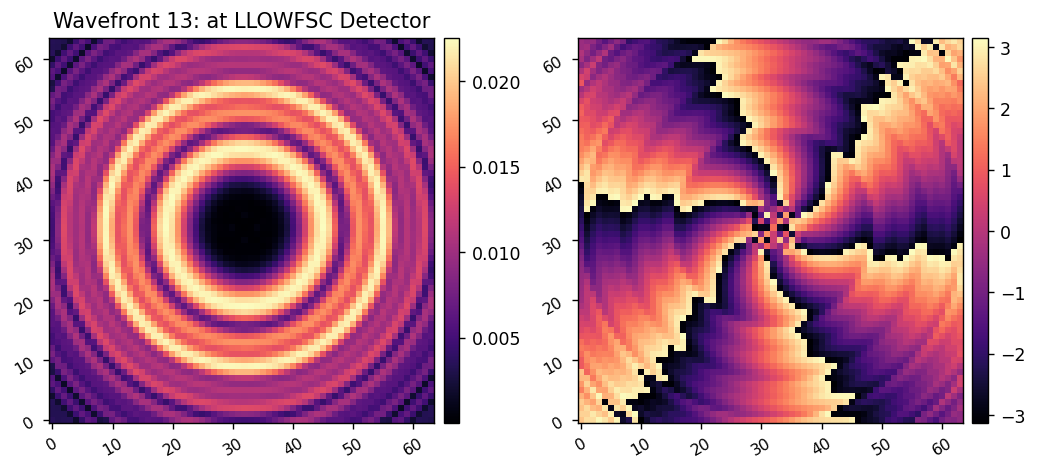

In [117]:
for i in range(len(wfs)):
    if 'focal plane' in wfs[i].location.lower() or 'detector' in wfs[i].location.lower():
        npix = wfs[i].shape[0]
    else:
        npix = 2*model.npix
    imshow2(wfs[i].amplitude, wfs[i].phase, f'Wavefront {i}: ' + wfs[i].location, npix=npix)
    